# 1. Context
## 1.1 Problem Statement

Customer Personality Analysis is a detailed analysis of a company’s ideal dfomers. It helps a business to better understand its dfomers and makes it easier for them to modify products according to the specific needs, behaviors and concerns of different types of dfomers.

Customer personality analysis helps a business to modify its product based on its target dfomers from different types of dfomer segments. For example, instead of spending money to market a new product to every dfomer in the company’s database, a company can analyze which dfomer segment is most likely to buy the product and then market the product only on that particular segment.


In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_columns',None)
import decimal

import plotly as py
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)
import matplotlib.lines as lines
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

PALETTE = ['#dd4124','#009473', '#b4b4b4', '#336b87']

%matplotlib inline

In [154]:
# pip install plotly

In [2]:
df = pd.read_csv( "marketing_campaign.csv",sep='\t')


In [3]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


# **2. Preprocessing**

In [4]:
# df.head()
# df.shape #(2240,29)
# df.info() #information about the dataframe
col = df.isnull().sum() #Income column having 24 missing values
col = col[col>0]
print(f'Column: {col.index[0]} having {col.values[0]} missing values')



Column: Income having 24 missing values


In [5]:
df.describe().T.style.bar(subset=['mean'], color='#606ff2')\
                            .background_gradient(subset=['std'], cmap='PuBu')\
                            .background_gradient(subset=['50%'], cmap='PuBu')

,count,mean,std,min,25%,50%,75%,max
ID,2240.000000,5592.159821,3246.662198,0.000000,2828.250000,5458.500000,8427.750000,11191.000000
Year_Birth,2240.000000,1968.805804,11.984069,1893.000000,1959.000000,1970.000000,1977.000000,1996.000000
Income,2216.000000,52247.251354,25173.076661,1730.000000,35303.000000,51381.500000,68522.000000,666666.000000
Kidhome,2240.000000,0.444196,0.538398,0.000000,0.000000,0.000000,1.000000,2.000000
Teenhome,2240.000000,0.506250,0.544538,0.000000,0.000000,0.000000,1.000000,2.000000
Recency,2240.000000,49.109375,28.962453,0.000000,24.000000,49.000000,74.000000,99.000000
MntWines,2240.000000,303.935714,336.597393,0.000000,23.750000,173.500000,504.250000,1493.000000
MntFruits,2240.000000,26.302232,39.773434,0.000000,1.000000,8.000000,33.000000,199.000000
MntMeatProducts,2240.000000,166.950000,225.715373,0.000000,16.000000,67.000000,232.000000,1725.000000
MntFishProducts,2240.000000,37.525446,54.628979,0.000000,3.000000,12.000000,50.000000,259.000000


In [6]:
df['Kids'] = df['Kidhome'] + df['Teenhome']

re_marital = {
    'Single': 'Not in relationship',
    'Together': 'In relationship',
    'Married': 'In relationship',
    'Divorced': 'Not in relationship',
    'Widow': 'Not in relationship',
    'Alone': 'Not in relationship',
    'Absurd': 'Not in relationship',
    'YOLO': 'Not in relationship'
}

df['Marital_Status'] = df['Marital_Status'].map(re_marital)

df['Family_size'] = 0



In [7]:
for i in range(len(df)):
    
    if df['Marital_Status'][i] == 'In relationship':
        df['Family_size'][i] = 2 + df['Kids'][i]
    else:
        df['Family_size'][i] = 1 + df['Kids'][i]

In [8]:
df['Marital_Status'][0]

'Not in relationship'

Let's highlight the age and time that a person is a client.

In [9]:
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])
df['Dt_Customer'].max(), df['Dt_Customer'].min()

(Timestamp('2014-12-06 00:00:00'), Timestamp('2012-01-08 00:00:00'))

We will assume that the customer information was collected 2014-12-07.

In [10]:
df['Age'] = 2014 - df['Year_Birth']
df['Collected'] = '2014-12-07'
df['Collected'] = pd.to_datetime(df['Collected'])
df['Days_is_client'] = (df['Collected'] - df['Dt_Customer']).dt.days

And some more information about purchases.

In [11]:
df['MntTotal'] = df['MntWines']+df['MntFruits']+df['MntMeatProducts']+df['MntFishProducts']+df['MntSweetProducts']+df['MntGoldProds']
df['NumAllPurchases'] = df['NumWebPurchases']+df['NumCatalogPurchases']+df['NumStorePurchases']
df['AverageCheck'] = round((df['MntTotal'] / df['NumAllPurchases']), 1)
df['ShareDealsPurchases'] = round((df['NumDealsPurchases'] / df['NumAllPurchases']) * 100, 1)
df['TotalAcceptedCmp'] = df['AcceptedCmp1']+df['AcceptedCmp2']+df['AcceptedCmp3']+df['AcceptedCmp4']+df['AcceptedCmp5']+df['Response']

There are some logic errors in data, so 6 clients spent money, but did not make a single order - I will delete them.

In [12]:
df = df.query("NumAllPurchases != 0")

8 Outliers in Income where 7 Customer's `Income` is near 150000
and there is 1 Customer having `Income` greater than 600000

Filling missing values with median you can also use mean.

In [13]:
median = df['Income'].median()
mean = df['Income'].mean()

dif = mean - median
print(f'Income Median: {round(median)}\nIncome Mean: {round(mean)}\ndifference: {round(dif)}')

df['Income'].fillna(median, inplace = True)

Income Median: 51400
Income Mean: 52242
difference: 842


Droping useless columns

In [14]:
df.drop(['ID', 'Year_Birth', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Z_CostContact', 'Z_Revenue', 'Collected'], axis = 1, inplace = True)

**Converting outliers.**

In [15]:
df['Income'] = np.where(df['Income'] > 120000, 120000, df['Income'])
df['AverageCheck'] = np.where(df['AverageCheck'] > 200, 200, df['AverageCheck'])

And finally, calculate the difference between how long a person has been a client and the count of days from the last purchase.

In [16]:
df['ActiveDays'] = df['Days_is_client'] - df['Recency']

In [17]:
df.head().style.background_gradient(cmap="Wistia",text_color_threshold=0.01)

,Education,Marital_Status,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Kids,Family_size,Age,Days_is_client,MntTotal,NumAllPurchases,AverageCheck,ShareDealsPurchases,TotalAcceptedCmp,ActiveDays
0,Graduation,Not in relationship,58138.000000,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,0,1,57,972,1617,22,73.500000,13.600000,1,914
1,Graduation,Not in relationship,46344.000000,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,2,3,60,126,27,4,6.800000,50.000000,0,88
2,Graduation,In relationship,71613.000000,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,0,2,49,473,776,20,38.800000,5.000000,0,447
3,Graduation,In relationship,26646.000000,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,1,3,30,66,53,6,8.800000,33.300000,0,40
4,PhD,In relationship,58293.000000,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,1,3,33,322,422,14,30.100000,35.700000,0,228


# **3. Data Visualization**

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2234 entries, 0 to 2239
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2234 non-null   object 
 1   Marital_Status       2234 non-null   object 
 2   Income               2234 non-null   float64
 3   Recency              2234 non-null   int64  
 4   MntWines             2234 non-null   int64  
 5   MntFruits            2234 non-null   int64  
 6   MntMeatProducts      2234 non-null   int64  
 7   MntFishProducts      2234 non-null   int64  
 8   MntSweetProducts     2234 non-null   int64  
 9   MntGoldProds         2234 non-null   int64  
 10  NumDealsPurchases    2234 non-null   int64  
 11  NumWebPurchases      2234 non-null   int64  
 12  NumCatalogPurchases  2234 non-null   int64  
 13  NumStorePurchases    2234 non-null   int64  
 14  NumWebVisitsMonth    2234 non-null   int64  
 15  AcceptedCmp3         2234 non-null   i

<AxesSubplot:>

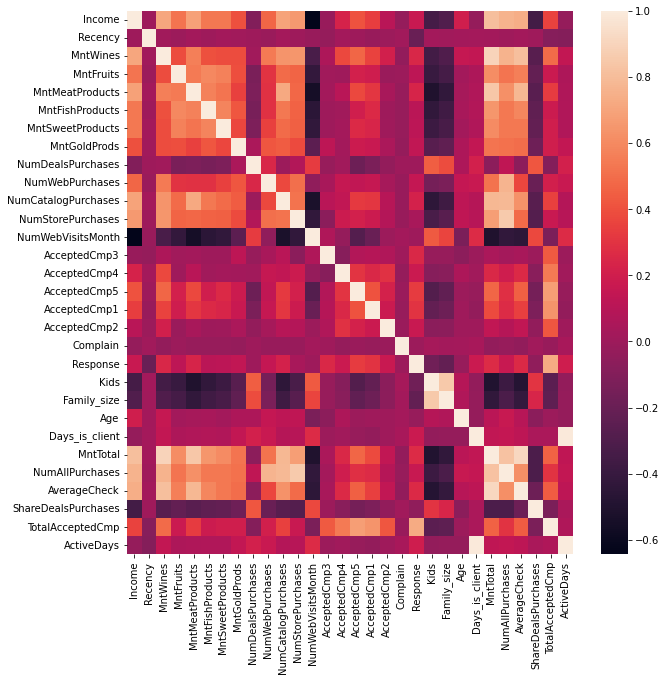

In [20]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr())


In [21]:

object_cols = [col for col in df.columns if df[col].dtype == "object"]
object_cols
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for object_cols in object_cols:
    df[object_cols] = le.fit_transform(df[object_cols])


In [22]:
df.columns

Index(['Education', 'Marital_Status', 'Income', 'Recency', 'MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Response', 'Kids', 'Family_size', 'Age',
       'Days_is_client', 'MntTotal', 'NumAllPurchases', 'AverageCheck',
       'ShareDealsPurchases', 'TotalAcceptedCmp', 'ActiveDays'],
      dtype='object')

In [23]:
from sdv.tabular import GaussianCopula
model = GaussianCopula()
model.fit(df)

In [24]:
sample = model.sample(1000)
sample.head()

,Education,Marital_Status,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Kids,Family_size,Age,Days_is_client,MntTotal,NumAllPurchases,AverageCheck,ShareDealsPurchases,TotalAcceptedCmp,ActiveDays
0,4,1,66176.7,44,163,80,261,48,29,75,2,4,1,4,6,0,0,0,0,0,0,0,0,2,39,288,476,7,50.6,23.8,1,264
1,2,1,39163.6,92,1,0,17,3,2,5,2,2,0,2,6,0,0,0,0,0,0,0,1,3,58,669,116,5,14.1,31.2,0,504
2,1,0,73766.7,44,457,61,453,104,118,74,0,5,5,8,4,0,0,0,0,0,0,0,0,1,29,742,1634,21,81.9,0.0,1,702
3,2,0,71930.8,10,167,57,145,24,43,82,2,12,3,13,4,0,0,0,0,0,0,0,1,3,56,534,689,25,25.4,15.2,0,532
4,1,0,9216.5,25,0,1,0,1,15,49,2,1,0,4,7,0,0,0,0,0,0,0,1,4,52,585,8,3,3.1,29.3,0,516


In [25]:
df = df.append(sample)

In [26]:
df_x_dummies = pd.get_dummies(df.drop(["Response"], axis=1))
y = df['Response']

In [27]:
print('missing values for each column')
for col, i in enumerate(df_x_dummies):
    print(df_x_dummies.columns[col], ':',df_x_dummies[i].isna().sum())

missing values for each column
Education : 0
Marital_Status : 0
Income : 0
Recency : 0
MntWines : 0
MntFruits : 0
MntMeatProducts : 0
MntFishProducts : 0
MntSweetProducts : 0
MntGoldProds : 0
NumDealsPurchases : 0
NumWebPurchases : 0
NumCatalogPurchases : 0
NumStorePurchases : 0
NumWebVisitsMonth : 0
AcceptedCmp3 : 0
AcceptedCmp4 : 0
AcceptedCmp5 : 0
AcceptedCmp1 : 0
AcceptedCmp2 : 0
Complain : 0
Kids : 0
Family_size : 0
Age : 0
Days_is_client : 0
MntTotal : 0
NumAllPurchases : 0
AverageCheck : 0
ShareDealsPurchases : 0
TotalAcceptedCmp : 0
ActiveDays : 0


In [28]:
X = df_x_dummies
y = df['Response']

# feature selection using Random Forest

In [29]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X, y)

SelectFromModel(estimator=RandomForestClassifier())

In [30]:
sel.get_support()

array([False, False,  True,  True,  True, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True, False,
        True, False,  True,  True])

In [31]:
selected_feat= X.columns[(sel.get_support())]
len(selected_feat)

9

In [36]:
print(selected_feat)

Index(['Income', 'Recency', 'MntWines', 'MntMeatProducts', 'Days_is_client',
       'MntTotal', 'AverageCheck', 'TotalAcceptedCmp', 'ActiveDays'],
      dtype='object')


In [38]:
X = X[selected_feat]

<AxesSubplot:>

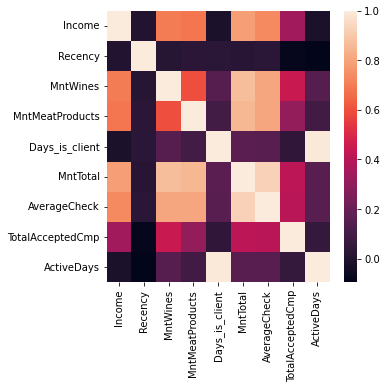

In [40]:
plt.figure(figsize=(5, 5))
sns.heatmap(X.corr())

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [42]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [43]:
X_train.shape

(2587, 9)

# XG Booste

In [44]:
from xgboost import XGBClassifier
xg_classifier = XGBClassifier()
xg_classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [45]:
y_pred = xg_classifier.predict(X_test)

from sklearn.metrics import confusion_matrix

confusion_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                                index = ['True[0]', 'True[1]'],
                               columns = ['Predict[0]', 'Predict[1]'])
print(confusion_matrix)


from sklearn.metrics import accuracy_score

print('accuracy is :', accuracy_score(y_test, y_pred)*100)

         Predict[0]  Predict[1]
True[0]         519          28
True[1]          41          59
accuracy is : 89.3353941267388


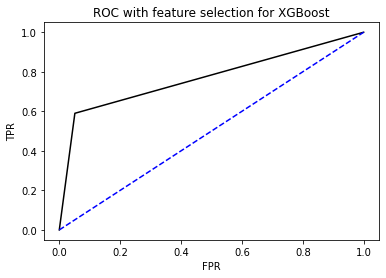

In [46]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)

plt.plot(fpr, tpr, 'k')
plt.plot([0, 1], [0, 1], 'b--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC with feature selection for XGBoost')
plt. show()

# Random forest

In [47]:
from sklearn.ensemble import RandomForestClassifier
rand_for_classifier = RandomForestClassifier()
rand_for_classifier.fit(X_train, y_train)

RandomForestClassifier()

In [48]:
y_pred = rand_for_classifier.predict(X_test)

from sklearn.metrics import confusion_matrix

confusion_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                                index = ['True[0]', 'True[1]'],
                               columns = ['Predict[0]', 'Predict[1]'])
print(confusion_matrix)



         Predict[0]  Predict[1]
True[0]         521          26
True[1]          38          62


In [49]:

from sklearn.metrics import accuracy_score

print('accuracy is :', accuracy_score(y_test, y_pred)*100)

accuracy is : 90.1081916537867


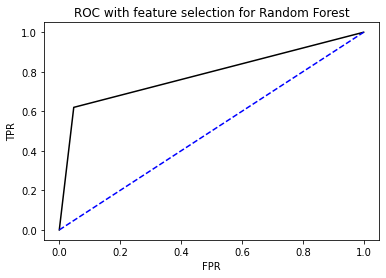

In [50]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)

plt.plot(fpr, tpr, 'k')
plt.plot([0, 1], [0, 1], 'b--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC with feature selection for Random Forest')
plt. show()

# KNN

In [51]:
from sklearn.neighbors import KNeighborsClassifier

classifier_knn = KNeighborsClassifier(n_neighbors=3, weights = 'distance')
classifier_knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3, weights='distance')

In [52]:
y_pred = classifier_knn.predict(X_test)

In [53]:
from sklearn.metrics import confusion_matrix

confusion_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                                index = ['True[0]', 'True[1]'],
                               columns = ['Predict[0]', 'Predict[1]'])
confusion_matrix

,Predict[0],Predict[1]
True[0],510,37
True[1],43,57


In [54]:
from sklearn.metrics import accuracy_score

print('accuracy is :', accuracy_score(y_test, y_pred)*100)

accuracy is : 87.63523956723338


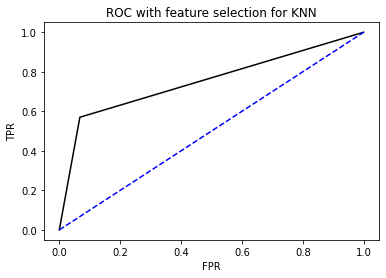

In [55]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)

plt.plot(fpr, tpr, 'k')
plt.plot([0, 1], [0, 1], 'b--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC with feature selection for KNN')
plt. show()